__Student info:__

- Student name: Thomas Brown
- Student pace: Full Time
- Scheduled project review date/time: TBD
- Instructor name: Abhineet Kulkarni
- Blog post URL: TBD

__Use Case:__<br><br>
The purpose of this project is to start building a neural network model that can determine the sentiment of financial news headlines.  The users of this model would be investment firms who want to keep track of the market sentiment of a set of various products, companies, or industries.  <br><br>
With proper web scraping and feeding of new headlines, a firm would be able to keep track of various topics to make better informed investing decisions.  For example, one could feasibly keep track of terms that are rising rapidly in terms of positive sentiment in order to invest in them.<br><br>
The data is collected from Kaggle through this [link](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).  It's a collection of 4,837 unique news headlines from various financial news sources. 

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Scikit-Learn:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import svm
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# Keras:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling1D
from keras.callbacks import EarlyStopping



# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet


# Sampling:
from imblearn.over_sampling import SMOTE, ADASYN

# XGBoost:
import xgboost as xgb

# Plots and Graphs:
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt 
%matplotlib inline

# Other:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# So we can see the entire column:
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.
/Users/Thomas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Importing Data:

In [2]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

,Sentiment,Headline
0,neutral,"The contract includes software licences , application maintenance and training ."
1,positive,Performance in the second half of 2009 exceeded expectations .
2,neutral,Related links : Flexiblebaseloadoperation TheWartsila32generating set Gasconversions This is the shorter of two versions of this press release .
3,neutral,"Founded in 1994 , the company uses a six-step , time-focused , collaborative project approach to improve financial institutions ' revenue streams ."
4,neutral,"The business units of the InvestLesProm Group cover the full forest industry chain , and the Group owns forests , sawmills , paper and pulp mills , and other processing plants ."


Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Sentiment    4846 non-null object
Headline     4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [3]:
# Let's take a look at the number of instances of each sentiment:
df.Sentiment.value_counts()
# Not too many negatives.  This may prove to be an issue later on, but for now, let's keep moving.

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

# Cleaning Data:

First, the labels need to be changed to numerical values in order to go through the neural network later on. Due to a low number of negative articles compared to the rest, I'll be treating this as a binary problem: 'Positive' vs 'Not Positive'.

- 0 is Negative or Neutral
- 1 is Positive

In [4]:
# BINARY
df['Sentiment'] = df['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df.head()

,Sentiment,Headline
0,0,"The contract includes software licences , application maintenance and training ."
1,1,Performance in the second half of 2009 exceeded expectations .
2,0,Related links : Flexiblebaseloadoperation TheWartsila32generating set Gasconversions This is the shorter of two versions of this press release .
3,0,"Founded in 1994 , the company uses a six-step , time-focused , collaborative project approach to improve financial institutions ' revenue streams ."
4,0,"The business units of the InvestLesProm Group cover the full forest industry chain , and the Group owns forests , sawmills , paper and pulp mills , and other processing plants ."


## Stopwords:

Next, we can remove all the 'stopwords' that can clog up the system later on.  The punctuation will get filtered out later.

In [5]:
stop = set(stopwords.words('english'))
stop.add("'s")
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [6]:
df.head()

,Sentiment,Headline
0,0,"contract includes software licences , application maintenance training ."
1,1,performance second half 2009 exceeded expectations .
2,0,related links : flexiblebaseloadoperation thewartsila32generating set gasconversions shorter two versions press release .
3,0,"founded 1994 , company uses six-step , time-focused , collaborative project approach improve financial institutions ' revenue streams ."
4,0,"business units investlesprom group cover full forest industry chain , group owns forests , sawmills , paper pulp mills , processing plants ."


## Lemmatization:

In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [9]:
# Still looking good
df.head()

,Sentiment,Headline
0,0,"contract include software licence , application maintenance training ."
1,1,performance second half 2009 exceed expectation .
2,0,related link : flexiblebaseloadoperation thewartsila32generating set gasconversions shorter two version press release .
3,0,"found 1994 , company us six-step , time-focused , collaborative project approach improve financial institution ' revenue stream ."
4,0,"business unit investlesprom group cover full forest industry chain , group own forest , sawmill , paper pulp mill , processing plant ."


# EDA:

Let's explore some word clouds to see the most commonly occurring words for each label.

In [10]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [11]:
 def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    ###
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    ###
    

In [12]:
# Showing Word Clounds
#show_wordclouds()

Not too much useful information here.  There are some more words we can clean, but I would like to stay on the conservative side for now.

# Additional Cleaning:

As we saw above, there are a few words that are quite common that occur in all 3 labels.  We'll add this to these to the stop word list and run the headlines through the filter again:
- 'finnish'
- 'say'
- 'company'
I'm leaving in 'eur' for now as it doesn't appear heavily in the 'Neutral' category.  This may help later on.  Depending on how the neural network performs later, I may or may not activate the following cells.

In [13]:
# Taking out a few more stop words:
stop.add("finnish")
stop.add("say")
stop.add("company")

df['Headline'] = df['Headline'].map(remove_stopwords)

In [14]:
# Starting to feel a little like caveman speak, but hopefully this will be easier for the model to read!
df.head()

,Sentiment,Headline
0,0,"contract include software licence , application maintenance training ."
1,1,performance second half 2009 exceed expectation .
2,0,related link : flexiblebaseloadoperation thewartsila32generating set gasconversions shorter two version press release .
3,0,"found 1994 , us six-step , time-focused , collaborative project approach improve financial institution ' revenue stream ."
4,0,"business unit investlesprom group cover full forest industry chain , group forest , sawmill , paper pulp mill , processing plant ."


In [15]:
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]


In [16]:
# Showing Word Clounds with additional words removed
#show_wordclouds()

# Counter:

In [17]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [18]:
text = df.Headline
counter = counter_word(text)

In [19]:
len(counter)

10094

In [20]:
# showing the first 25 rows of the counter
n = 25
out = dict(list(counter.items())[0: n])  
out

{'contract': 177,
 'include': 196,
 'software': 75,
 'licence': 7,
 ',': 4662,
 'application': 57,
 'maintenance': 33,
 'training': 10,
 '.': 4780,
 'performance': 33,
 'second': 83,
 'half': 57,
 '2009': 297,
 'exceed': 4,
 'expectation': 5,
 'related': 34,
 'link': 11,
 ':': 363,
 'flexiblebaseloadoperation': 1,
 'thewartsila32generating': 1,
 'set': 36,
 'gasconversions': 1,
 'shorter': 1,
 'two': 85,
 'version': 10}

In [21]:
num_words = len(counter)

# Train/Test Split:

In [22]:
# Generating the lists of headlines and labels
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [23]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) # Out of 4846

In [24]:
# Train Test Split:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [25]:
# Looks good
display(training_headlines[:3])
display(training_labels[:3])

['contract include software licence , application maintenance training .',
 'performance second half 2009 exceed expectation .',
 'related link : flexiblebaseloadoperation thewartsila32generating set gasconversions shorter two version press release .']

[0, 1, 0]

# Tokenization:

In [26]:
vocab_size = len(counter) # approx 1/5 of the words 
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [27]:

# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)


In [28]:
# Switch to Numpy Array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [29]:
# Example of what's happening under the hood:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [ 645 3731  455  343 1754  179 2590 3732   71  875  237   72 1524   90
  162 1221    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 found 1994 , us six-step , time-focused , collaborative project approach improve financial institution ' revenue stream .

Label:
 0


## Taking a Look at Inputs:

In [30]:
# So far looks good:
n = 0

display(training_headlines[n])
print('-----------------')
display(training_padded[n])
print('-----------------')
display(training_labels[n])
print('-----------------')

display(testing_headlines[n])
print('-----------------')
display(testing_padded[n])
print('-----------------')
display(testing_labels[n])
print('-----------------')


'contract include software licence , application maintenance training .'

-----------------


array([  49,   41,  144, 1358,  185,  366,  940,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


0

-----------------


'200 volunteer fiskars , garden tool , home depot ( nyse : hd ) , city baltimore neighborhood work right create garden sanctuary - single day .'

-----------------


array([ 439, 2862,  519, 1599,  577,  484, 2752,  746,    1,  326, 5237,
          1,  175,  151,  545, 1599,    1, 1248,  261,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


1

-----------------


In [31]:
# Making sure all our data works. . . 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '-') for i in text])

print(decode_sentence(training_padded[1]))
print(training_headlines[1])
print(labels[1])

performance second half 2009 exceed expectation - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
performance second half 2009 exceed expectation .
1


# Modeling:

## Baseline with TextBlob:

TextBlob is a common library used for NLP.  It may not be optimized for news headlines, though.  Let's see how accurate it is on this dataset, then see if we can improve the results with an artificial neural network.

In [32]:
from textblob import TextBlob
df2 = df # Setting up test environment
# Testing out some headlines
headline1 = "tesla lays off all employees" # News headline
headline2 = 'the food was very good'  # Basic easy statement
blob1 = TextBlob(headline1)
blob2 = TextBlob(headline2)
print(blob1.polarity)
print(blob2.polarity)

0.0
0.9099999999999999


In [33]:
'''
threshold = .1

for headline in df2['Headline']:
#    df2['tb_sent'] = (TextBlob(headline).polarity)
    df2['tb_sent'][headline] = (TextBlob(headline).polarity)
    
#for item in df['tb_sent']:
#    if item > threshold:
#        item = 1
#    else:
#        item = 0
'''

"\nthreshold = .1\n\nfor headline in df2['Headline']:\n#    df2['tb_sent'] = (TextBlob(headline).polarity)\n    df2['tb_sent'][headline] = (TextBlob(headline).polarity)\n    \n#for item in df['tb_sent']:\n#    if item > threshold:\n#        item = 1\n#    else:\n#        item = 0\n"

In [34]:
# TextBlob Accuracy:

## Baseline with Vader:

Vader is another commonly used sentiment analysis toolbox.  Let's see if we can get better results with this.

In [35]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores('The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [36]:
# Vader Accuracy:

# Neural Network:

In [37]:
# First let's define the functions for model evaluation
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) # Was 8, 5 before
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
def easy_headlines():
    sentence = ["Stock rise rapid for Tesla", 
            "Apple factory shut down, lay off hundred employee",
           "Average day of return for Microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
def harder_headlines():
    sentence = ["Former Nissan Executive Greg Kelly Pleads Not Guilty at Tokyo Trial", 
            "Amazon to Hire 100,000 in U.S. and Canada",
           "Disney’s ‘Mulan’ Top China Box Office Amid Controversy"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

    
def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

Now it's time to build a baseline neural network:

## Model 1 (1 Hidden Layer):

In [75]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
#model.add(Dense(150, activation='relu')) # Optional second hidden layer
#model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

#Messing with learning rate
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code

In [76]:
num_epochs = 50
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 3s 647us/step - loss: 0.6451 - acc: 0.7198 - val_loss: 0.6062 - val_acc: 0.7155
Epoch 2/50
3876/3876 [==============================] - 2s 485us/step - loss: 0.5906 - acc: 0.7196 - val_loss: 0.5897 - val_acc: 0.7155
Epoch 3/50
3876/3876 [==============================] - 2s 490us/step - loss: 0.5838 - acc: 0.7196 - val_loss: 0.5875 - val_acc: 0.7155
Epoch 4/50
3876/3876 [==============================] - 2s 487us/step - loss: 0.5805 - acc: 0.7196 - val_loss: 0.5853 - val_acc: 0.7155
Epoch 5/50
3876/3876 [==============================] - 2s 486us/step - loss: 0.5763 - acc: 0.7196 - val_loss: 0.5823 - val_acc: 0.7155
Epoch 6/50
3876/3876 [==============================] - 2s 488us/step - loss: 0.5705 - acc: 0.7196 - val_loss: 0.5785 - val_acc: 0.7155
Epoch 7/50
3876/3876 [==============================] - 2s 487us/step - loss: 0.5643 - acc: 0.7198 - val_loss: 0.5734 - val_acc: 0.7155
E

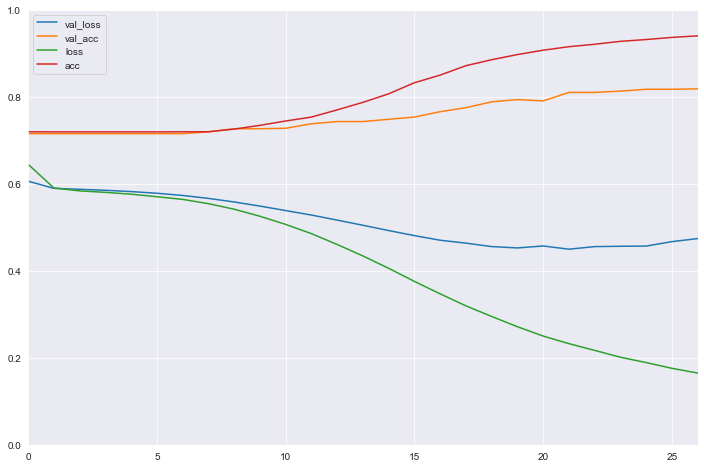

In [77]:
model_eval(history)

In [78]:
model_metrics(model)

Train Loss: 15.503%
Train Accuracy: 94.401%
Test Loss: 47.420%
Test Accuracy: 81.856%


In [79]:
test_headlines()

Easier Headlines:
Stock rise rapid for Tesla
Apple factory shut down, lay off hundred employee
Average day of return for Microsoft
[[0.71042013]
 [0.00271147]
 [0.25556785]]


Realistic Headlines:
Former Nissan Executive Greg Kelly Pleads Not Guilty at Tokyo Trial
Amazon to Hire 100,000 in U.S. and Canada
Disney’s ‘Mulan’ Top China Box Office Amid Controversy
[[0.08748842]
 [0.11250847]
 [0.02616401]]


## Model 2 (2 Hidden Layers):

In [80]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(200, activation='relu')) # Optional second hidden layer
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

#Messing with learning rate
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code


In [81]:
num_epochs = 50
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 3s 723us/step - loss: 0.6149 - acc: 0.7196 - val_loss: 0.5913 - val_acc: 0.7155
Epoch 2/50
3876/3876 [==============================] - 2s 556us/step - loss: 0.5859 - acc: 0.7196 - val_loss: 0.5882 - val_acc: 0.7155
Epoch 3/50
3876/3876 [==============================] - 2s 553us/step - loss: 0.5793 - acc: 0.7196 - val_loss: 0.5849 - val_acc: 0.7155
Epoch 4/50
3876/3876 [==============================] - 2s 550us/step - loss: 0.5709 - acc: 0.7196 - val_loss: 0.5738 - val_acc: 0.7155
Epoch 5/50
3876/3876 [==============================] - 2s 541us/step - loss: 0.5460 - acc: 0.7232 - val_loss: 0.5539 - val_acc: 0.7237
Epoch 6/50
3876/3876 [==============================] - 2s 546us/step - loss: 0.5042 - acc: 0.7485 - val_loss: 0.5243 - val_acc: 0.7412
Epoch 7/50
3876/3876 [==============================] - 2s 549us/step - loss: 0.4325 - acc: 0.7928 - val_loss: 0.4958 - val_acc: 0.7485
E

### Model Evaluation:

In [82]:
model_metrics(model)

Train Loss: 11.462%
Train Accuracy: 96.491%
Test Loss: 53.000%
Test Accuracy: 80.928%


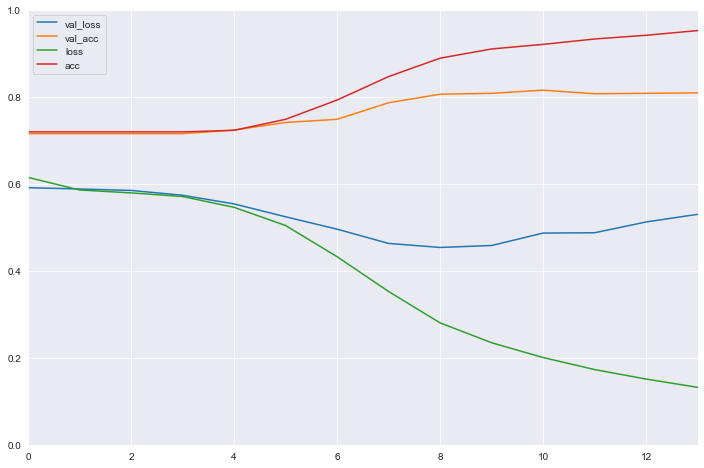

In [83]:
model_eval(history)

In [84]:
test_headlines()

Easier Headlines:
Stock rise rapid for Tesla
Apple factory shut down, lay off hundred employee
Average day of return for Microsoft
[[9.2770290e-01]
 [9.2171901e-04]
 [4.4472435e-01]]


Realistic Headlines:
Former Nissan Executive Greg Kelly Pleads Not Guilty at Tokyo Trial
Amazon to Hire 100,000 in U.S. and Canada
Disney’s ‘Mulan’ Top China Box Office Amid Controversy
[[0.07866773]
 [0.12760141]
 [0.00863425]]


## Model 3 (LSTM):

LSTM (Long Short Term Memory) models are quite popular as well for NLP.  Let's give it a try.

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [44]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.6037 - acc: 0.7178 - val_loss: 0.5981 - val_acc: 0.7155
Epoch 2/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.5606 - acc: 0.7330 - val_loss: 0.5139 - val_acc: 0.7557
Epoch 3/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.3926 - acc: 0.8372 - val_loss: 0.4870 - val_acc: 0.7773
Epoch 4/50
3876/3876 [==============================] - 11s 3ms/step - loss: 0.2332 - acc: 0.9177 - val_loss: 0.4655 - val_acc: 0.7938
Epoch 5/50
3876/3876 [==============================] - 11s 3ms/step - loss: 0.1592 - acc: 0.9499 - val_loss: 0.6533 - val_acc: 0.7938
Epoch 6/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.1197 - acc: 0.9696 - val_loss: 0.5885 - val_acc: 0.7866
Epoch 7/50
3876/3876 [==============================] - 10s 2ms/step - loss: 0.0920 - acc: 0.9757 - val_loss: 0.7813 - val_acc: 0.7825
Epoch 8/

### Model Evaluation:

In [45]:
model_metrics(model)

Train Loss: 4.590%
Train Accuracy: 99.071%
Test Loss: 80.585%
Test Accuracy: 78.866%


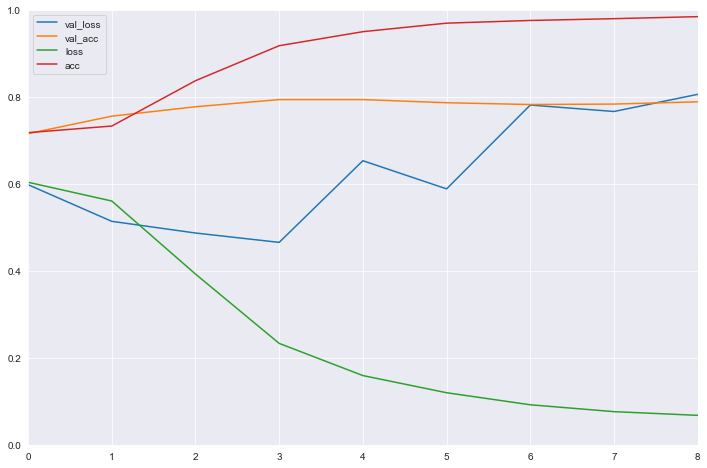

In [46]:
model_eval(history)

In [47]:
test_headlines()

Easier Headlines:
Stock rise rapid for Tesla
Apple factory shut down, lay off hundred employee
Average day of return for Microsoft
[[0.9881402 ]
 [0.00393428]
 [0.4292873 ]]


Realistic Headlines:
Former Nissan Executive Greg Kelly Pleads Not Guilty at Tokyo Trial
Amazon to Hire 100,000 in U.S. and Canada
Disney’s ‘Mulan’ Top China Box Office Amid Controversy
[[0.00465407]
 [0.1300371 ]
 [0.00394056]]


## Embedding Model 2:

This model has some different architecture than the first.  Let's see if we can improve our accuracy. 

In [85]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(0.2), # Optional Regularization
    keras.layers.Dense(50, activation='relu'), # Optional second hidden layer
    keras.layers.Dropout(0.2), # Optional Regularization
    keras.layers.Dense(1, activation='sigmoid')])

opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer = opt, metrics=['accuracy']) # Orig code


In [86]:
#model.summary()

In [87]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 1s 356us/step - loss: 0.6780 - acc: 0.6850 - val_loss: 0.6590 - val_acc: 0.7155
Epoch 2/50
3876/3876 [==============================] - 1s 168us/step - loss: 0.6398 - acc: 0.7196 - val_loss: 0.6203 - val_acc: 0.7155
Epoch 3/50
3876/3876 [==============================] - 1s 170us/step - loss: 0.6044 - acc: 0.7196 - val_loss: 0.5961 - val_acc: 0.7155
Epoch 4/50
3876/3876 [==============================] - 1s 167us/step - loss: 0.5925 - acc: 0.7196 - val_loss: 0.5909 - val_acc: 0.7155
Epoch 5/50
3876/3876 [==============================] - 1s 169us/step - loss: 0.5867 - acc: 0.7196 - val_loss: 0.5893 - val_acc: 0.7155
Epoch 6/50
3876/3876 [==============================] - 1s 166us/step - loss: 0.5861 - acc: 0.7196 - val_loss: 0.5881 - val_acc: 0.7155
Epoch 7/50
3876/3876 [==============================] - 1s 168us/step - loss: 0.5822 - acc: 0.7196 - val_loss: 0.5869 - val_acc: 0.7155
E

### Model Evaluation:

In [88]:
model_metrics(model)

Train Loss: 16.885%
Train Accuracy: 94.685%
Test Loss: 45.678%
Test Accuracy: 80.928%


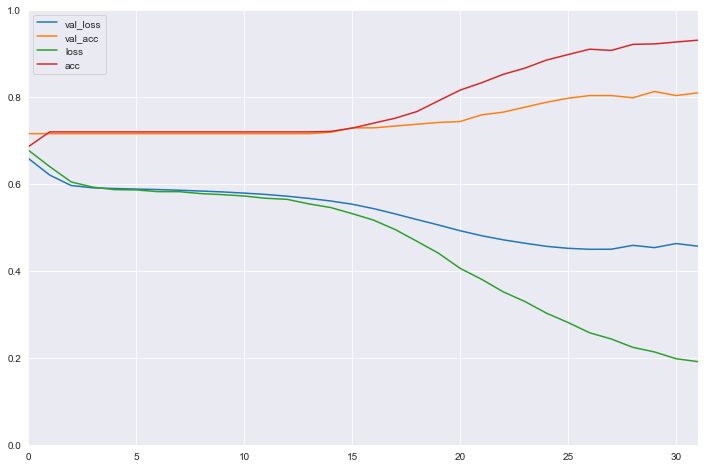

In [89]:
model_eval(history)

In [90]:
test_headlines()

Easier Headlines:
Stock rise rapid for Tesla
Apple factory shut down, lay off hundred employee
Average day of return for Microsoft
[[0.6812949 ]
 [0.00660908]
 [0.29143056]]


Realistic Headlines:
Former Nissan Executive Greg Kelly Pleads Not Guilty at Tokyo Trial
Amazon to Hire 100,000 in U.S. and Canada
Disney’s ‘Mulan’ Top China Box Office Amid Controversy
[[0.13547942]
 [0.18799335]
 [0.03867002]]


# Final Model:

## Final Model Evaluation:

# Other:

In [54]:
print break_

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(break_)? (<ipython-input-54-8dc0057c2caf>, line 1)

In [91]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10094, 32)


In [ ]:
'''
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

# Further Work:

In the future, I'd like to complete the following analysis:
- A web application that collects and analyzes headlines from various financial news sources.
- Other neural network architecture types.
- New types of sentiment analysis, such as breaking news vs an opinion piece on an older issue.
- Rate different newspapers by sentiment value.

# Conclusion: